In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib import patches
from scipy.spatial.distance import euclidean
import warnings
warnings.simplefilter('ignore')
RS1_x, RS1_y = 125, 150
RS2_x, RS2_y = 175, 150

In [2]:
def center_base(RS1_x, RS1_y, RS2_x, RS2_y):
    if(RS1_x < RS2_x):
        center_base_x = RS1_x + (RS2_x - RS1_x) / 2
    else: 
        center_base_x = RS2_x + (RS1_x - RS2_x) / 2
    if(RS1_y < RS2_y):
        center_base_y = RS1_y + (RS2_y - RS1_y) / 2
    else: 
        center_base_y = RS2_y + (RS1_y - RS2_y) / 2
    return [center_base_x, center_base_y]

In [3]:
class Error:
    sigma_delta_tau0 = 0.000000005
    sigma_delta_phi = 1. * math.pi/180
    C = 300000
    num_point = 300
    P_e = 0.95
    pi = math.pi
    
    def psi(self, x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y):
        a = euclidean([x_tar, y_tar], [RS1_x, RS1_y])
        b = euclidean([x_tar, y_tar], [RS2_x, RS2_y])
        c = euclidean([RS1_x, RS1_y], [RS2_x, RS2_y])
        psi = math.acos((a**2+b**2-c**2)/(2*a*b))
        return psi


    def sigma_tau(self, R):
        return self.sigma_delta_tau0 * R


    def sigma_summ(self, R):
        return self.sigma_tau(R) * self.C
    
    
    def ksi(self):
        return math.sqrt(-math.log1p(-self.P_e))


    def sigma_pel(self, R):
        return self.sigma_delta_phi * R


    def sigma_ellip(self, x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y, R):
        return self.sigma_summ(R) / (2 * math.cos(self.psi(x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y)))


    def get_tangle_ellip(self, x_ellip, y_ellip, x_tar, y_tar):
        diff1, diff2 = np.diff([x_ellip, y_ellip])
        error = 2 * self.pi / self.num_point * 100
        num = -1
        for i in range(len(x_ellip)-1):
            if(abs(x_ellip[i] - x_tar) < error and abs(y_ellip[i] - y_tar) < error):
                num = i
                break
        if num >= 0:
            return [diff1[num], diff2[num]]
        else:
            return 0, 0
        
        
    def get_tangle_peleng(self, x_pel, y_pel):
        return [(x_pel[10]-x_pel[0]), (y_pel[10]-y_pel[0])]
    

    def get_alpha(self, x_ellip, y_ellip, x_tar, y_tar, x_pel, y_pel):
        tan_el = self.get_tangle_ellip(x_ellip, y_ellip, x_tar, y_tar)
        tan_pel = self.get_tangle_peleng(x_pel, y_pel)
        alpha = math.acos(np.dot(tan_el, tan_pel) / (np.linalg.norm(tan_el) * np.linalg.norm(tan_pel)))
        if alpha > self.pi / 2:
            alpha = self.pi - alpha
        return alpha


    def dist_sum(self, x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y):
        R1 = euclidean([x_tar, y_tar], [RS1_x, RS1_y])
        R2 = euclidean([x_tar, y_tar], [RS2_x, RS2_y])
        return R1 + R2
    
    
    def get_sigma_position_lines(self, x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y):
        R2 = euclidean([x_tar, y_tar], [RS2_x, RS2_y])
        R_sum = self.dist_sum(x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y)
        sigma_delta_ellip = self.sigma_ellip(x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y, R_sum)
        sigma_delta_pel = self.sigma_pel(R2)
        return sigma_delta_ellip, sigma_delta_pel


    def get_sigma_full(self, sigma1, sigma2, alpha):
        return math.sqrt(sigma1**2 + sigma2**2)/math.sin(alpha)


    def get_err(self, x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y, x_ellip, y_ellip,  x_pel, y_pel):
        sigma1, sigma2 = self.get_sigma_position_lines(x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y)
        alpha = self.get_alpha(x_ellip, y_ellip, x_tar, y_tar, x_pel, y_pel)
        if (alpha > self.pi / 2):
            alpha = self.pi - alpha
        sigma = self.get_sigma_full(sigma1, sigma2, alpha)
        return sigma
    
    
    def get_circle_err(self, x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y, x_ellip, y_ellip,  x_pel, y_pel):
        sigma = self.get_err(x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y, x_ellip, y_ellip,  x_pel, y_pel)
        tetta = np.linspace(0, 2 * self.pi, self.num_point)
        R_ck = self.ksi() * sigma
        x = R_ck * np.cos(tetta) + x_tar
        y = R_ck * np.sin(tetta) + y_tar
        return x, y

In [4]:
class PositionLine:
    num_point = 300
    
    def ellipse(self, x0, y0, summa, base):
        a = summa / 2
        c = base / 2
        b = math.sqrt((a**2 - c**2))
        tetta = np.linspace(0, 2 * math.pi, self.num_point)
        x = a * np.cos(tetta) + x0
        y = b * np.sin(tetta) + y0
        return x, y
    

    def peleng(self, x0, y0, x_tar, y_tar):
        vec_x = x_tar - x0
        vec_y = y_tar - y0
        tetta = math.atan(vec_y / vec_x)
        if(vec_x < 0):
            x = np.linspace(0, -self.num_point, self.num_point * 10)
        else:
            x = np.linspace(0, self.num_point, self.num_point * 10)
        y = math.tan(tetta) * x
        return x + x0, y + y0
    
    
    def get_position_lines(self, x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y):
        R_sum = Error().dist_sum(x_tar, y_tar, RS1_x, RS1_y, RS2_x, RS2_y)
        base = euclidean([RS1_x, RS1_y], [RS2_x, RS2_y])
        center_base_x, center_base_y = center_base(RS1_x, RS1_y, RS2_x, RS2_y)
        return [self.ellipse(center_base_x, center_base_y, R_sum, base),
                self.peleng(RS2_x, RS2_y, x_tar, y_tar)]

In [5]:
class KalmanFilterConstCoefficient:
    T0 = 0.02
    
    def __init__(self, alpha):
        self.alpha = alpha;
        self.beta = alpha**2 / (2 - alpha)
        
        
    def extrapolate(self, speed, curr):
        a = np.array([[1, self.T0], [0, 1]])
        b = np.array([curr, speed])
        return a @ b

    
    def estimate(self, curr, extra):
        return extra + self.alpha * (curr - extra)


    def speed(self, curr, last, last_speed=0):
        return last_speed + self.beta / self.T0 * (curr - last)
    
    
    def filtred_coordinates(self, X, Y):
        last_coor = np.array([X[0], Y[0]])
        curr_coor = np.array([X[1], Y[1]])
        speed_coor = self.speed(curr_coor, last_coor)
        coor = np.array([last_coor, curr_coor])
        for i in range(2, len(X)):
            extra  = self.extrapolate(speed_coor, coor[-1])
            last_coor = curr_coor
            curr_coor = np.array([X[i], Y[i]])
            speed_coor = self.speed(curr_coor, last_coor)
            coor = np.append(coor, [self.estimate(curr_coor, extra[0])], axis=0)
        return coor

In [6]:
class KalmanFilterVariableCoefficient(KalmanFilterConstCoefficient):
    def __init__(self, alpha_zone, R_zone, RS1_x, RS1_y, RS2_x, RS2_y):
        super().__init__(0)
        self.R_zone = R_zone
        self.alpha_zone = alpha_zone
        self.beta_zone = alpha_zone**2 / (2 - alpha_zone)
        self.center_base_x, self.center_base_y = center_base(RS1_x, RS1_y, RS2_x, RS2_y)
        
        
    def filtred_coordinates(self, X, Y):
        last_coor = np.array([X[0], Y[0]])
        curr_coor = np.array([X[1], Y[1]])
        R = euclidean([X[1], Y[1]], [self.center_base_x, self.center_base_y])
        self.alpha = self.alpha_zone[(abs(self.R_zone - R)).argmin()]
        self.beta = self.beta_zone[(abs(self.R_zone - R)).argmin()]
        speed_coor = self.speed(curr_coor, last_coor)
        coor = np.array([last_coor, curr_coor])
        for i in range(2, len(X)):
            extra  = self.extrapolate(speed_coor, coor[-1])
            last_coor = curr_coor
            curr_coor = np.array([X[i], Y[i]])
            R = euclidean([X[i], Y[i]], [self.center_base_x, self.center_base_y])
            self.alpha = self.alpha_zone[(abs(self.R_zone - R)).argmin()]
            self.beta = self.beta_zone[(abs(self.R_zone - R)).argmin()]
            speed_coor = self.speed(curr_coor, last_coor)
            coor = np.append(coor, [self.estimate(curr_coor, extra[0])], axis=0)
        return coor

In [7]:
def noise_coordinates(X, Y, RS1_x, RS1_y, RS2_x, RS2_y):
    line = PositionLine()
    err = Error()
    X1, Y1 = X.copy(), Y.copy()
    coor = np.zeros((len(X), 2))
    for i in range(len(X)):
        ell, pel = line.get_position_lines(X1[i], Y1[i], RS1_x, RS1_y, RS2_x, RS2_y)
        sigma = err.get_err(X[i], Y[i], RS1_x, RS1_y, RS2_x, RS2_y, ell[0], ell[1],  pel[0], pel[1])
        X1[i] +=np.random.normal(0, sigma)
        Y1[i] +=np.random.normal(0, sigma)
        coor[i, :] = np.array([X1[i], Y1[i]])
    return coor

In [8]:
def sigma_extrapolate(X, Y, RS1_x, RS1_y, RS2_x, RS2_y, alpha, alpha_zone, R_zone):
    kf_const = KalmanFilterConstCoefficient(alpha)
    kf_var = KalmanFilterVariableCoefficient(alpha_zone, R_zone, RS1_x, RS1_y, RS2_x, RS2_y)
    num_point = len(X)
    extrapolate_const = np.zeros((1, num_point, 2))
    extrapolate_var = np.zeros((1, num_point, 2))
    mass_noise = np.zeros((1, num_point, 2))
    for _ in range(100):
        noise_coor = noise_coordinates(x1, y1, RS1_x, RS1_y, RS2_x, RS2_y)
        coor_const = kf_const.filtred_coordinates(noise_coor[:, 0], noise_coor[:, 1])
        coor_var = kf_var.filtred_coordinates(noise_coor[:, 0], noise_coor[:, 1])
        extrapolate_const = np.append(extrapolate_const, [coor_const], axis=0)
        extrapolate_var = np.append(extrapolate_var, [coor_var], axis=0)
        mass_noise = np.append(mass_noise, [noise_coor], axis=0)
    extrapolate_const_1 = np.zeros_like(extrapolate_const)
    extrapolate_var_1 = np.zeros_like(extrapolate_var)
    mass_noise_1 = np.zeros_like(mass_noise)
    for i in range(num_point):
        extrapolate_const_1[1:, i] = (extrapolate_const[1:, i] - np.array([X[i], Y[i]]))
        extrapolate_var_1[1:, i] = (extrapolate_var[1:, i] - np.array([X[i], Y[i]]))
        mass_noise_1[1:, i] = (mass_noise[1:, i] - np.array([X[i], Y[i]]))
    error_extrapolate_const = np.array([np.sqrt(extrapolate_const_1[1:, i, 0].std()**2 +\
                                extrapolate_const_1[1:, i, 1].std()**2) for i in range(num_point)])
    error_extrapolate_var = np.array([np.sqrt(extrapolate_var_1[1:, i, 0].std()**2 +\
                                extrapolate_var_1[1:, i, 1].std()**2) for i in range(num_point)])
    error_noise = np.array([np.sqrt(mass_noise_1[1:, i, 0].std()**2 +\
                                mass_noise_1[1:, i, 1].std()**2) for i in range(num_point)])
    return [error_extrapolate_const,
            error_extrapolate_var, 
            error_noise]

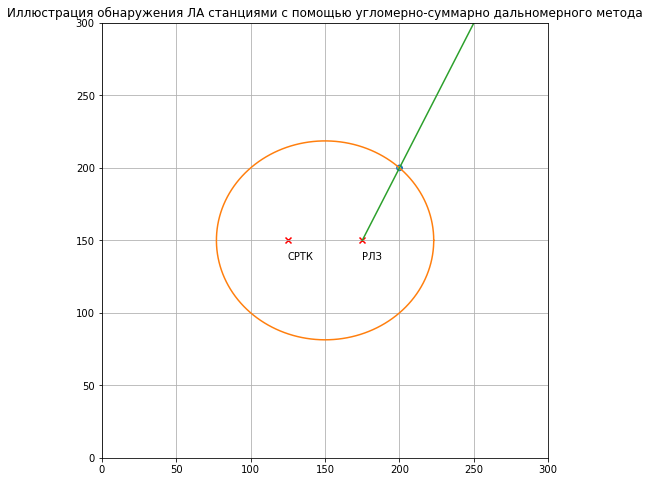

In [9]:
x_test, y_test = 200, 200
line = PositionLine()
err = Error()
ell, pel = line.get_position_lines(x_test, y_test, RS1_x, RS1_y, RS2_x, RS2_y)
circle_err = err.get_circle_err(x_test, y_test, RS1_x, RS1_y, RS2_x, RS2_y, ell[0], ell[1],  pel[0], pel[1])
f, ax = plt.subplots(figsize=(8,8))
plt.scatter([RS1_x, RS2_x], [RS1_y, RS2_y], c='red', marker='x')
plt.plot(circle_err[0], circle_err[1])
plt.plot(ell[0], ell[1])
plt.plot(pel[0], pel[1])
plt.ylim([0, 300])
plt.xlim([0, 300])
plt.text(RS1_x, RS1_y-13, 'СРТК')
plt.text(RS2_x, RS2_y-13, 'РЛЗ')
plt.grid()
plt.title("Иллюстрация обнаружения ЛА станциями с помощью угломерно-суммарно дальномерного метода")
plt.show()

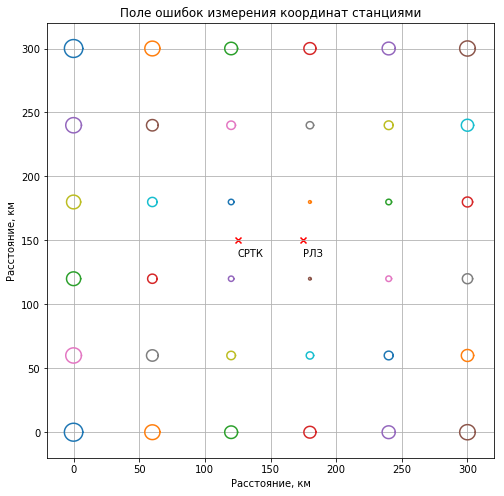

In [10]:
x_line = np.linspace(0, 300, 6)
y_line = np.linspace(0, 300, 6)
x_test, y_test = np.meshgrid(x_line, y_line)
f, ax = plt.subplots(figsize=(8,8))
plt.scatter([RS1_x, RS2_x], [RS1_y, RS2_y], c='red', marker='x')
ax.text(RS1_x, RS1_y-13, 'СРТК')
ax.text(RS2_x, RS2_y-13, 'РЛЗ')
plt.ylim([-20, 320])
plt.xlim([-20, 320])
plt.grid()
plt.xlabel('Расстояние, км')
plt.ylabel('Расстояние, км')
plt.title("Поле ошибок измерения координат станциями")
line = PositionLine()
err = Error()
for i in range(len(x_line)):
    for j in range(len(y_line)):
        x0, y0 = x_test[i,j], y_test[i,j]
        ell, pel = line.get_position_lines(x0, y0, RS1_x, RS1_y, RS2_x, RS2_y)
        circle_err = err.get_circle_err(x0, y0, RS1_x, RS1_y, RS2_x, RS2_y, ell[0], ell[1],  pel[0], pel[1])
        plt.plot(circle_err[0], circle_err[1])
plt.show()

In [11]:
R_zone = np.array([0, 112.5, 187.5, 262.5])
alpha_zone = np.array([0.4, 0.13, 0.11, 0.06])
alpha = 0.32
center_base_x, center_base_y = center_base(RS1_x, RS1_y, RS2_x, RS2_y)
t = np.linspace(0, 1.3 * math.pi, 200)
x = np.arange(-150, 150, 1.5)
y = 200 * np.sin(t)
x1 = x + center_base_x + 30
y1 = y + center_base_y

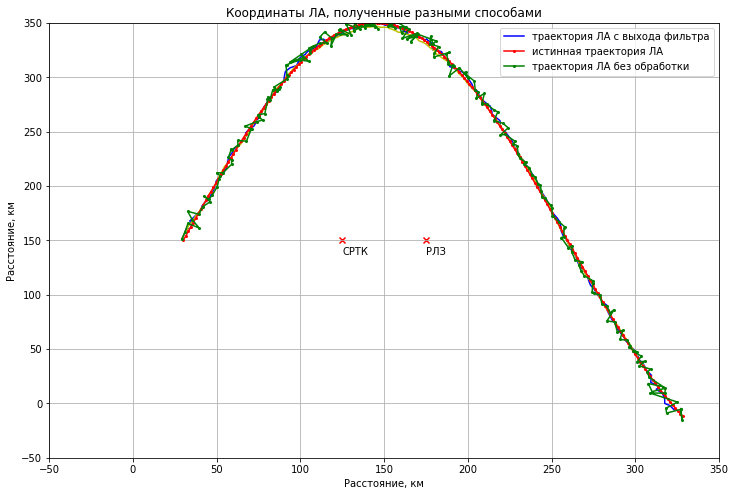

In [12]:
noise_coor = noise_coordinates(x1, y1, RS1_x, RS1_y, RS2_x, RS2_y)
kf = KalmanFilterConstCoefficient(alpha)
kf1 = KalmanFilterVariableCoefficient(alpha_zone, R_zone, RS1_x, RS1_y, RS2_x, RS2_y)
coor = kf.filtred_coordinates(noise_coor[:, 0], noise_coor[:, 1])
coor1 = kf1.filtred_coordinates(noise_coor[:, 0], noise_coor[:, 1])
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(coor[:, 0], coor[:, 1], color='b', label='траектория ЛА с выхода фильтра')
ax.plot(coor1[:, 0], coor1[:, 1], color='y')
ax.plot(x1, y1, color='r', label='истинная траектория ЛА', marker='o', markersize=2)
ax.plot(noise_coor[:, 0], noise_coor[:, 1], color='g', label='траектория ЛА без обработки', marker='o', markersize=2)
ax.grid()
ax.scatter([RS1_x, RS2_x], [RS1_y, RS2_y], c='red', marker='x')
ax.text(RS1_x, RS1_y-13, 'СРТК')
ax.text(RS2_x, RS2_y-13, 'РЛЗ')
ax.set_xlabel('Расстояние, км')
ax.set_ylabel('Расстояние, км')
ax.set_xlim([-50, 350])
ax.set_ylim([-50, 350])
ax.legend()
plt.title("Координаты ЛА, полученные разными способами")
plt.show()

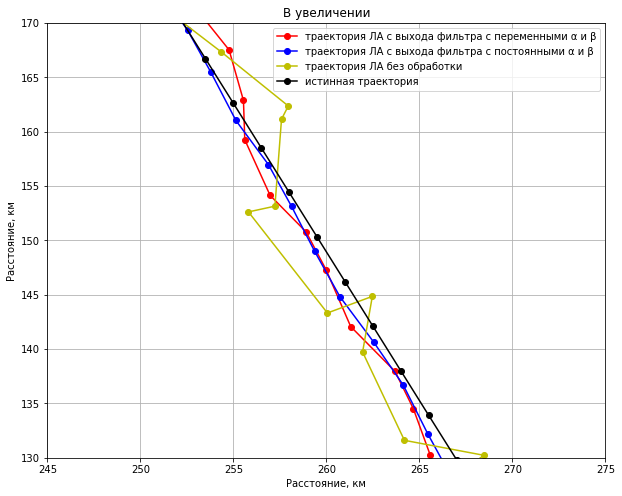

In [13]:
import unicodedata
fig, ax = plt.subplots(figsize=(10, 8))
# ax.contourf(XX1, XX2, Z, cmap='CMRmap_r')
ax.plot(coor[:, 0],
        coor[:, 1],
        color='r',
        label=('траектория ЛА с выхода фильтра c переменными ' +  
               unicodedata.lookup("GREEK SMALL LETTER ALPHA") + 
               ' и ' + unicodedata.lookup("GREEK SMALL LETTER BETA")),
        marker='o')
ax.plot(coor1[:, 0],
        coor1[:, 1],
        color='b',
        label=('траектория ЛА с выхода фильтра c постоянными ' +  
               unicodedata.lookup("GREEK SMALL LETTER ALPHA") + 
               ' и ' + unicodedata.lookup("GREEK SMALL LETTER BETA")), 
        marker='o')
ax.plot(noise_coor[:, 0], noise_coor[:, 1], color='y', label='траектория ЛА без обработки', marker='o')
ax.plot(x1, y1, color='black', label='истинная траектория', marker='o')
ax.grid()
ax.scatter([RS1_x, RS2_x], [RS1_y, RS2_y], c='red', marker='x')
ax.set_xlim([245, 275])
ax.set_ylim([130, 170])
ax.legend()
ax.set_xlabel('Расстояние, км')
ax.set_ylabel('Расстояние, км')
plt.title("В увеличении")
plt.show()

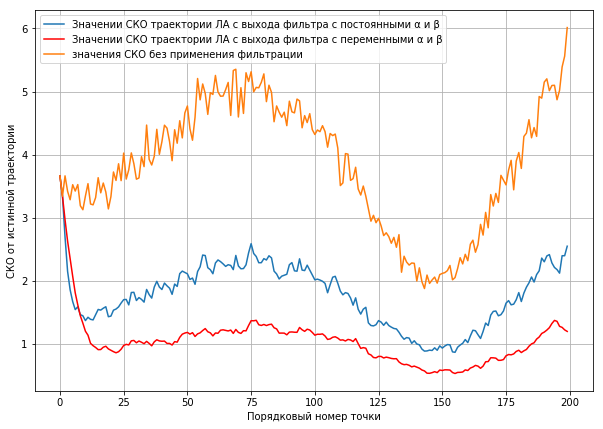

In [14]:
sigma_const, sigma_var, sigma_noise = sigma_extrapolate(x1, x1, RS1_x, RS1_y, RS2_x, RS2_y, alpha, alpha_zone, R_zone)
f, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel('Порядковый номер точки')
ax.set_ylabel('СКО от истинной траектории')
ax.plot(sigma_const, label=('Значении СКО траектории ЛА с выхода фильтра c постоянными ' +  
               unicodedata.lookup("GREEK SMALL LETTER ALPHA") + 
               ' и ' + unicodedata.lookup("GREEK SMALL LETTER BETA")))
plt.plot(sigma_var, color='r', label=('Значении СКО траектории ЛА с выхода фильтра c переменными ' +  
               unicodedata.lookup("GREEK SMALL LETTER ALPHA") + 
               ' и ' + unicodedata.lookup("GREEK SMALL LETTER BETA")))

ax.grid()
ax.plot(sigma_noise, label='значения СКО без применения фильтрации')
ax.legend()
plt.show()